In [120]:
import pandas as pd 
import os
import csv
import json
import glob
import re
import sys
import graphviz

In [108]:
# Import local libs
sys.path.append('../py')
from framework.utils.GitUtils import GitManager

In [3]:
def createDirIfNotExists(folder_name):
    if not os.path.isdir(folder_name): 
        os.makedirs(folder_name)

In [4]:
root="/home/jovyan/work"
analysis_results_path = root + "/analysis/results/"
createDirIfNotExists(analysis_results_path)

In [5]:
def searchRegression(results):
    candidates = []
    success_results = [ r for r in results if r['ExecuteTest'] ]
    if len(success_results) > 1:
        first_success_found = success_results[1]
        
        # BORDER CASE: REGRESSION IS IN PREV COMMIT
        if first_success_found['id'] == 2:
            candidates.append(results[1]['commit'][0:8])
            
        for result in reversed(results[2:first_success_found['id']]):
            candidates.append(result['commit'][0:8])
            if result['Build'] and result['BuildTest']: break
                
    return candidates

In [433]:
def generateResults(project, bug_id, bug_path=None):
    results = {}
    # TEMPORAL
    bug_name = "Bug_"+str(bug_id)
    bug_path = "{root}/results/{project}/{bug_name}/".format(root=root, project=project, bug_name=bug_name)
    
    # FOR EACH COMMIT
    for index, row in pd.read_csv(bug_path+'commit_history.csv').iterrows():
        commit_path = bug_path+"commits/{id}-{c_hash}/".format(id=row['id'], c_hash=row['hash'])
        if os.path.isfile(commit_path+"result.json"):
            gm = GitManager(
                "{root}/projects/{project}_Bug_{bug_id}".format(root=root, bug_id=bug_id, project=project),
                row['hash']
            )
            with open(commit_path+"result.json") as f:
                raw_result = json.load(f)
                result = {
                    'id': row['id'],
                    'commit': row['hash'],
                    'Build': raw_result['isSourceBuildSuccess'],
                    'BuildTest': raw_result['isTestBuildSuccess'],
                    'ExecuteTest': raw_result['isTestExecutionSuccess'],
                    'HasTestReport': os.path.isfile(commit_path+"test-report.xml"),
                    'parents': gm.getParents(row['hash'])
                }
#                 if index > 50: 
#                     result['parents'] = []
#                     break
                
                results[row['hash']] = result 
        
            
    return results

In [438]:
dot = graphviz.Digraph(comment="JacksonCore")

# Reduce nodes
results = generateResults("JacksonCore",11)

fix_commit = results['be4386724ff18232aff492cb9145288df86ea61c']

for result in results.values():
    for parent_hash in result['parents']:
        if parent_hash == "" or parent_hash not in results: continue
        if not 'children' in results[parent_hash]:
            results[parent_hash]['children'] = []
        results[parent_hash]['children'].append(result['commit'])
        
reduced = []

reduced_results = {}
def reduceGraph(results, c_hash, add=True):
    
    if c_hash in reduced_results:
        return reduced_results[c_hash]['id'], reduced_results[c_hash]['parents']
    
    if not c_hash in results: return
    
    current_commit = results[c_hash].copy()
    
    if not add:
        reduced.append(current_commit['id'])
    
    parents = current_commit['parents']
    new_parents = []
    
    
    if len(parents) == 1:
        parent_hash = parents[0]
        if parent_hash == "" or parent_hash not in results: return "END", []
        if results[parent_hash]['ExecuteTest'] == current_commit['ExecuteTest']:
            # Reduce
            if len(results[parent_hash]['children']) >= 2 and current_commit['id'] not in reduced:
                
                add = True
                reduceGraph(results, parent_hash)
            else:
    
                if len(results[parent_hash]['parents']) >= 2:
                    reduceGraph(results, parent_hash)
                else:
                    addParent = len(results[parent_hash]['children']) >= 2
                    if addParent:
                        reduceGraph(results, parent_hash)
                    else:
                        last_id, new_parents = reduceGraph(results, parent_hash, add=False)
                        current_commit['parents'] = new_parents
                        if add:
                            current_commit['id'] = str(current_commit['id']) + "-" + str(last_id)
                        else:
                            current_commit['id'] = last_id
        else:
            reduceGraph(results, parent_hash)
    else:
        add = True
        for parent_hash in parents:
            reduceGraph(results, parent_hash)
            
    if add: reduced_results[c_hash] = current_commit

    return current_commit['id'], current_commit['parents']
        
reduceGraph(results, fix_commit['commit'])

(0, ['7ca3d1cb6f1317863b5b04a1b0a7bac2aee5eefd'])

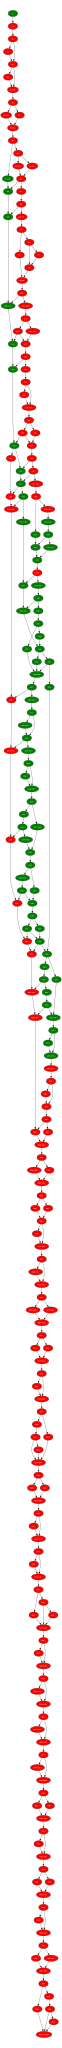

In [439]:
for c_hash, result in reduced_results.items():
    color = 'green' if result['ExecuteTest'] else 'red'
    node_id = str(result['id'])
    
    dot.node(
        result['commit'],
        node_id,
        style='filled',
        fontcolor='white',
        fillcolor=color
    )

for c_hash, result in reduced_results.items():
    for parent in result['parents']:
        dot.edge(result['commit'], parent)
dot.format = 'svg'
dot.render("JacksonCore-Reduced")
dot

In [185]:
def analyzeBug(project, bug_id):
    
    bug_name = "Bug_"+str(bug_id)
    bug_path = "{root}/results/{project}/{bug_name}/".format(root=root, project=project, bug_name=bug_name)
    
    with open("{root}/configFiles/{project}/bugs/{bug_name}.json".format(root=root,project=project, bug_name=bug_name)) as f:
        bug_info = json.load(f)
        
    test_name = re.search(r"-Dtest=(.*) test",bug_info['test_command']).group(1)

    bug_result = {
        'id': project + "_" + bug_name,
        'bug': bug_name,
        'project': project,
        "fix_pass": True,
        "prev_fails": True,
        "category": None,
        "test_name": test_name,
        "bug_report": bug_info['bug_report'],
        "fix_commit": bug_info['fix_commit'],
        "BIC_candidates": [],
        "sub_category": "-"
    }
    
    if not os.path.isfile(bug_path+'commit_history.csv'):
        print(bug_path+'commit_history.csv')
        bug_result['category'] = "Other error"
        return bug_result
    
    results_dir = analysis_results_path+"{project}/{bug_name}/".format(project=project, bug_name=bug_name)
    createDirIfNotExists(results_dir)

    results = generateResults(project, bug_id, bug_path)
    
    fix_result = results[0]
    
    if not fix_result['ExecuteTest']: # FIX COMMIT - SHOULD PASS
        
        bug_result['category'] = "Test fails in the fix commit"
        bug_result['fix_pass'] = False
        bug_result['prev_fails'] = None
        
        if fix_result['Build']:
            if fix_result['BuildTest']:
                if not fix_result['HasTestReport']:
                    bug_result['sub_category'] = "The test was not executed"
                else:
                    bug_result['sub_category'] = "Test execution fails"
            else:
                bug_result['sub_category'] = "Failure in test build"
        else:
            bug_result['sub_category'] = "Failure in source build"
    
    else: 
        
        prev_result = results[1]
        
        if prev_result['ExecuteTest']: # PREV COMMIT - SHOULD NOT PASS
            bug_result['category'] = "Test passes in the commit prior to the fix"
            bug_result['prev_fails'] = False
        else:
        
            # SEARCH FOR BIC IF FIX COMMIT PASS AND PREV COMMIT FAILS
            if bug_result['fix_pass'] and bug_result['prev_fails']:

                # SEARCH REGRESSION
                candidates = searchRegression(results)
                if len(candidates) > 0:

                    bug_result['BIC_candidates'] = candidates
                    bug_result['category'] = "A regression is detected"

                    if len(candidates) == 1:
                        bug_result['sub_category'] = "Unique candidates" 
                    else:
                        bug_result['sub_category'] = "Multiple candidates" 

                # SEARCH OTHER BIC
                else:

                    success_test_build = [ r for r in results if r['BuildTest'] ]
                    candidate_commit = success_test_build[-1]
                    if candidate_commit['id']+1 == len(results):
                        # Candidate commit is first commit
                        bug_result['sub_category'] = "Reach first commit"
                    else:
                        candidate_commit_antecesor = results[candidate_commit['id']+1]
                        if candidate_commit_antecesor['Build']:
                            bug_result['sub_category'] = "Failure in test build"
                        else:
                            bug_result['sub_category'] = "Failure in source build" 
                    bug_result['BIC_candidates'] = [(candidate_commit['commit'][0:8])]
                    bug_result['category'] = "No regression is detected"
    
    # Save bug result
    with open(results_dir+"bug_result.json",'w+') as json_file:
        json.dump(bug_result, json_file, indent=4)
    
    # SAVE COMMIT HISTORY
    with open(results_dir+"commit_history_results.csv", 'w+') as csvfile: 
        writer = csv.DictWriter(csvfile, fieldnames = results[0].keys()) 
        writer.writeheader()
        writer.writerows(results)

    return bug_result

In [112]:
project_test = "JacksonCore"
bug=11
analyzeBug(project_test, bug)

{'id': 'JacksonCore_Bug_11',
 'bug': 'Bug_11',
 'project': 'JacksonCore',
 'fix_pass': True,
 'prev_fails': True,
 'category': 'A regression is detected',
 'test_name': 'com.fasterxml.jackson.core.sym.SymbolsViaParserTest#testSymbolTableExpansionBytes',
 'bug_report': 'https://github.com/FasterXML/jackson-core/issues/216',
 'fix_commit': 'be4386724ff18232aff492cb9145288df86ea61c',
 'BIC_candidates': ['ca3efaae'],
 'sub_category': 'Unique candidates'}

In [95]:
projects = [
    "JacksonXml", "Time", "Collections", "Compress", "Csv", "JacksonCore", "JacksonDatabind", "Gson", "Jsoup"
]
bug_results = []
for project in projects:
    # FOR EACH BUG
    for bug_path in glob.glob("{root}/results/{project}/Bug_*/".format(root=root, project=project)):
        bug = re.search(r"Bug_(\d+)", bug_path).group(1)
        try:
            bug_result = analyzeBug(project, bug)
            bug_results.append(bug_result)  
        except Exception as e:
            print(bug_path)
            print(e)

In [96]:
df = pd.DataFrame(bug_results)[['id', 'category', 'sub_category']]
df[df['category'] != None].set_index('id').sort_index()
print(len(df))
df['category'].value_counts()

348


No regression is detected                     246
Test fails in the fix commit                   47
A regression is detected                       43
Test passes in the commit prior to the fix     12
Name: category, dtype: int64

In [18]:
#df[df['category']=='Test failed at fix commit']
df.groupby(['category', "sub_category"]).count()['id']

category                                    sub_category             
A regression is detected                    Multiple candidates           10
                                            Unique candidates             33
No regression is detected                   Failure in source build      117
                                            Failure in test build        127
                                            Reach first commit             2
Test fails in the fix commit                Failure in source build       22
                                            Failure in test build          3
                                            Test execution fails           6
                                            The test was not executed     16
Test passes in the commit prior to the fix  -                             12
Name: id, dtype: int64

In [19]:
df_projects = pd.DataFrame(bug_results)[['id', 'category', 'sub_category', 'project']]
df_projects[df_projects['project']=="Jsoup"].groupby(['category', "sub_category"]).count()['id']

category                      sub_category           
A regression is detected      Unique candidates           8
No regression is detected     Failure in source build     1
                              Failure in test build      82
Test fails in the fix commit  Test execution fails        2
Name: id, dtype: int64

In [21]:
df[df['category']=='Test fails in the fix commit'][df['sub_category']=='Test execution fails']

/tmp/ipykernel_150732/3653276638.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['category']=='Test fails in the fix commit'][df['sub_category']=='Test execution fails']


,id,category,sub_category
12,Time_Bug_9,Test fails in the fix commit,Test execution fails
16,Time_Bug_8,Test fails in the fix commit,Test execution fails
23,Time_Bug_7,Test fails in the fix commit,Test execution fails
26,Time_Bug_16,Test fails in the fix commit,Test execution fails
257,Jsoup_Bug_67,Test fails in the fix commit,Test execution fails
334,Jsoup_Bug_78,Test fails in the fix commit,Test execution fails
